# EDA and Data Preparation
This notebook uses [Pytorch's MTCNN](https://pypi.org/project/facenet-pytorch/) face detector to extract the faces from the images and [Movenet model from TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/movenet) for extracting poses.


## Prerequisites
* Install the pytorch's facenet library using `!pip install facenet-pytorch`
* Download [lightning](https://tfhub.dev/google/movenet/singlepose/lightning/4) version of the movenet model from the TF hub.
* Good to enable GPU as the inference is a little faster on it.
## Step 0: Notebook Initialization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install facenet_pytorch

In [2]:
import time
import os
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import configuration
import customdataset
import enums
import numpy as np
import pandas as pd
import eda_helpers
from tqdm.notebook import tqdm
# import transformers
from torch.utils.data import DataLoader
import seaborn as sns
from torchvision import transforms
import transformers
import feature_helpers

device = 'cpu'
config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)

IMAGE_TYPES = [enums.ImageTypes.ORIGINAL, enums.ImageTypes.POSE, enums.ImageTypes.FACE]
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)


## Step 1: Understanding The Data

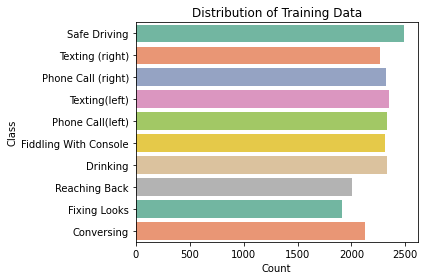

In [3]:

def plot_counts():    
    classes = list(config.class_dict.keys())
    classes.sort()
    d = {"img" : [], "class" : []}
    for c in classes:
        imgs = [img for img in os.listdir(os.path.join(config.TRAIN_DATA, f'c{c}')) if not img.startswith(".")]
        for img in imgs:
            d["img"].append(img)
            d["class"].append(config.class_dict.get(c))
    df = pd.DataFrame(d)
    ax = sns.countplot(data=df, y="class", palette='Set2')
    ax.set(title="Distribution of Training Data")
    ax.set_xlabel('Count')
    ax.set_ylabel('Class')
    # ax.tick_params(axis='x', rotation=90)
    plt.savefig(f'{config.OUTPUT_FOLDER}/class_distribution.png', dpi=300, bbox_inches = "tight")
    plt.tight_layout()
    # print("Total Number Of Images In Training Data :",len(df))

plot_counts()

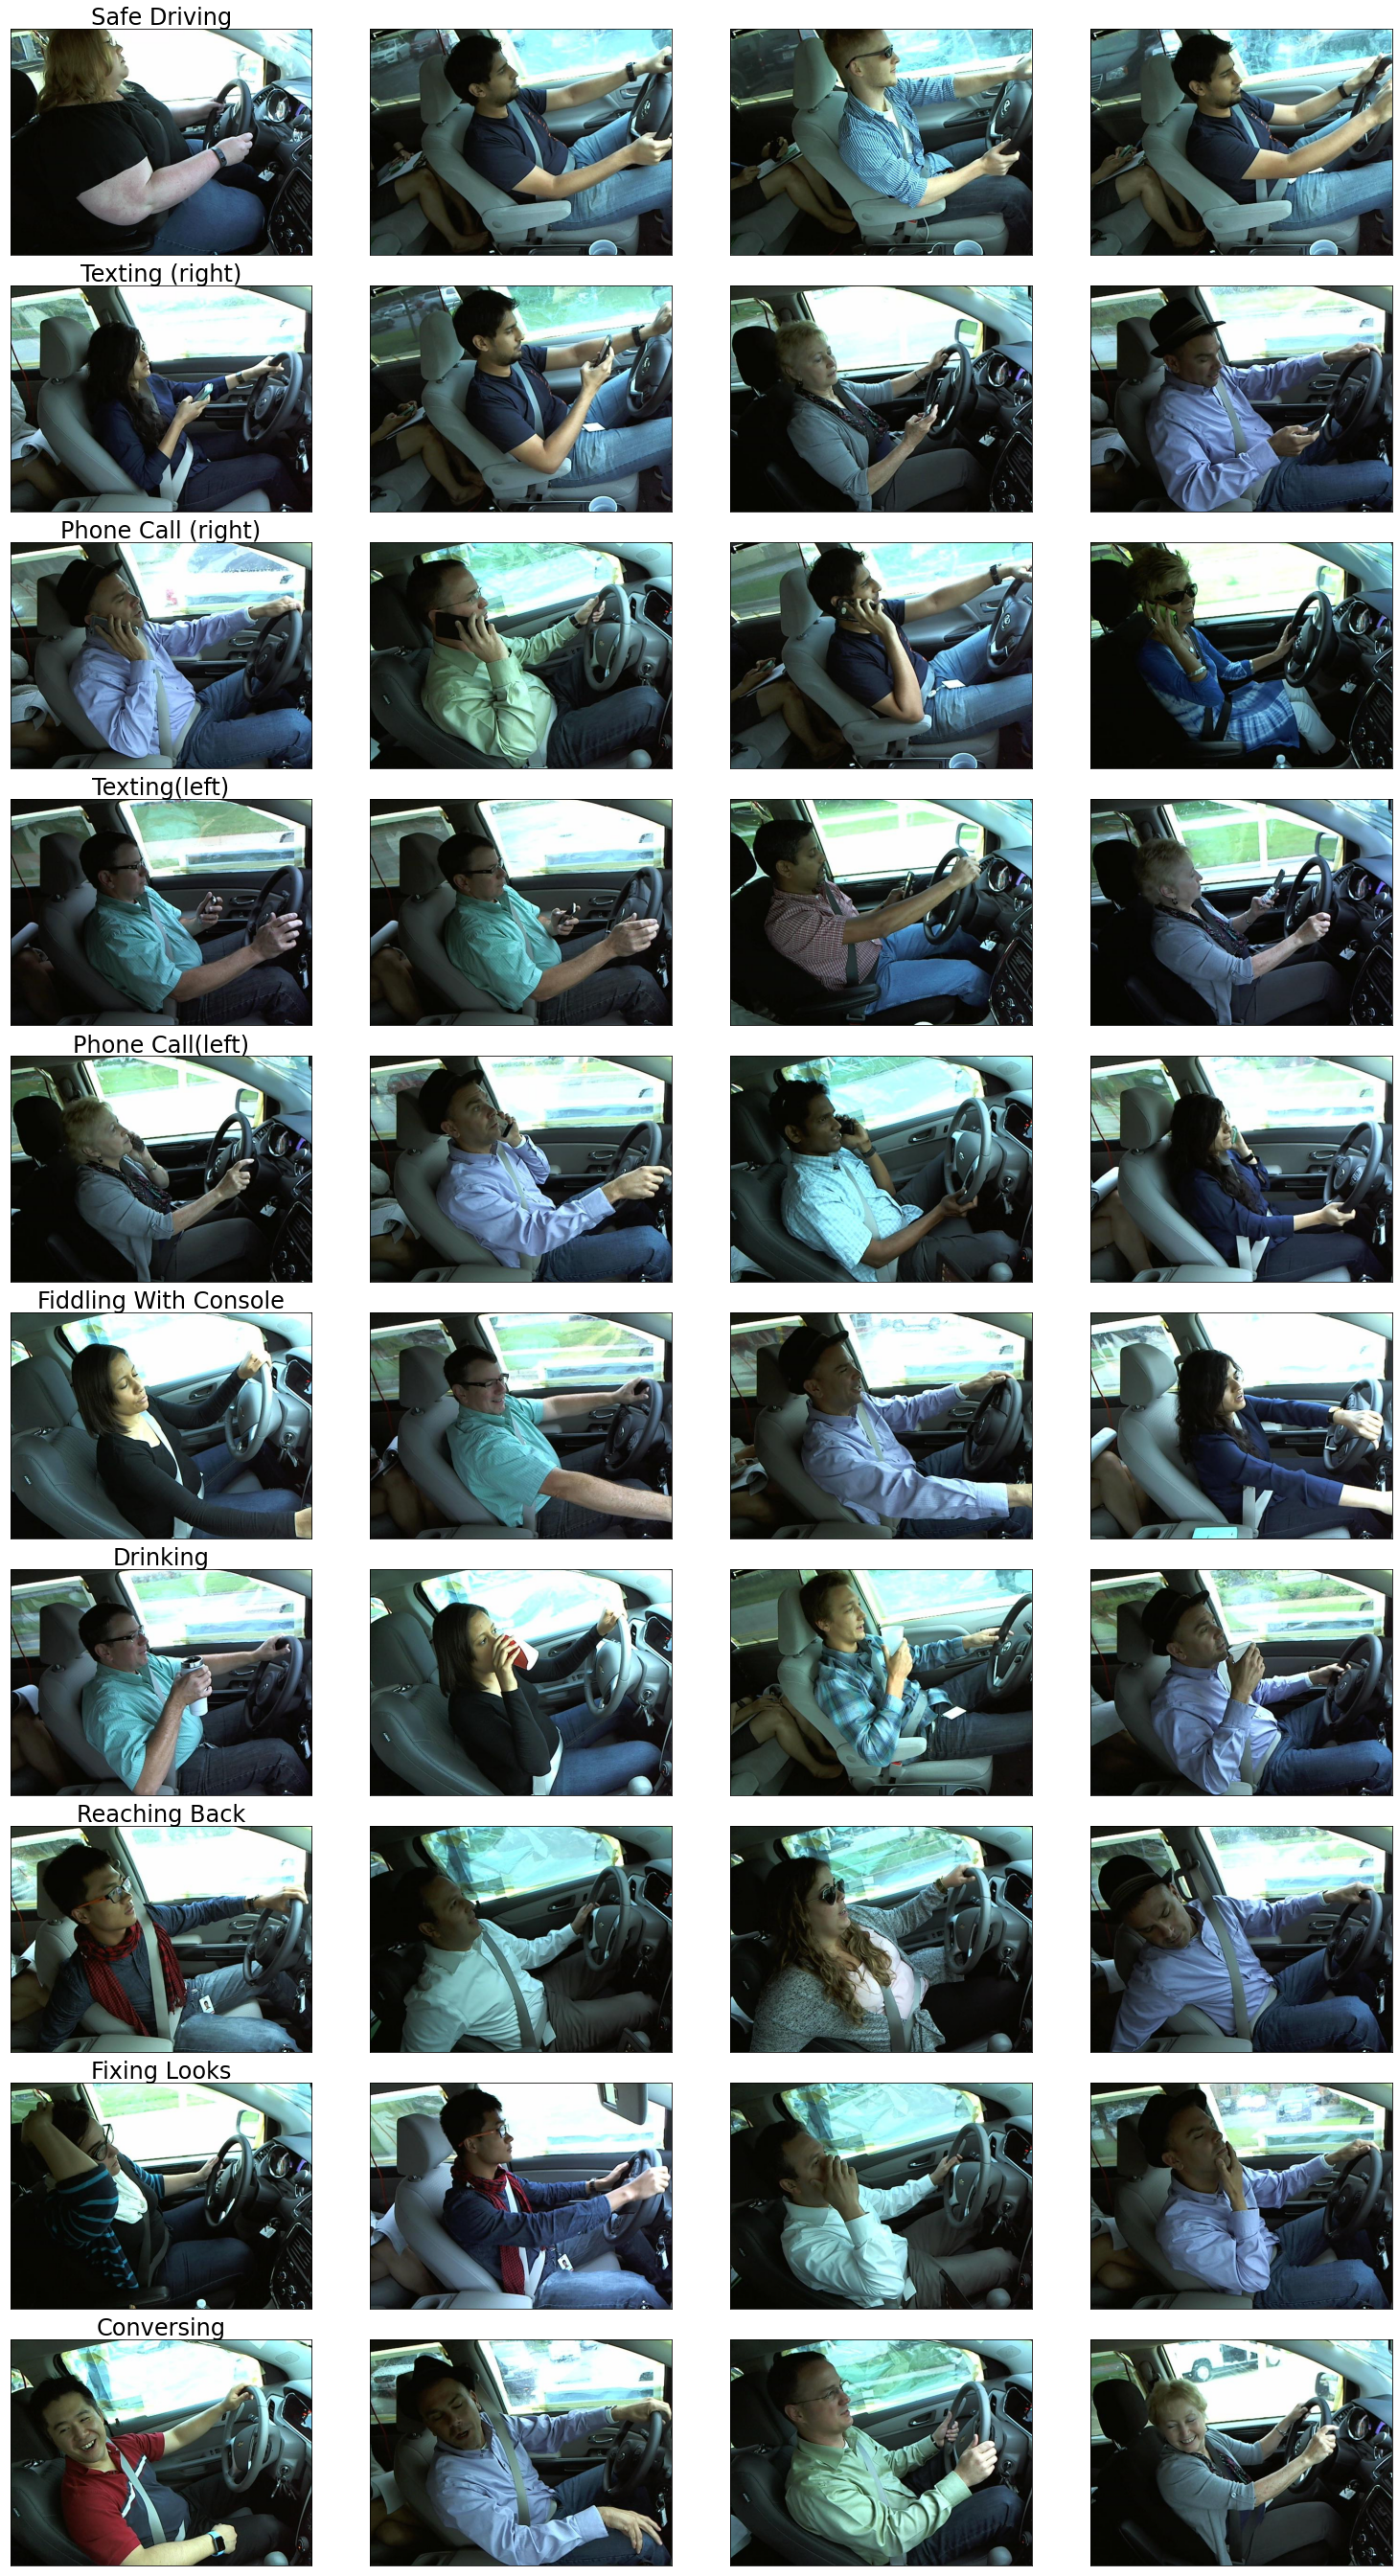

In [3]:
# Plot 10 images per category, with category name.
# TODO: Refactor and use dataloader for random sampling
def sample(c, num):
    # TODO: Do random sampling instead of the first num images.
    d = [os.path.join(config.TRAIN_DATA, f'c{c}', img) for img in os.listdir(os.path.join(config.TRAIN_DATA, f'c{c}')) if not img.startswith(".")]
    return d[0:num], config.class_dict.get(c)

def plot_samples(num=5):
    # load images per class
    # Display them in each row.
    fig, axes = plt.subplots(10, num, figsize=[21, 42])
    pad = 5 # in points
    classes = list(config.class_dict.keys())

    for row, class_code in enumerate(classes):
        imgs, class_name = sample(class_code, num)      
        for i, img_file in enumerate(imgs):
            img = plt.imread(img_file)
            axis = axes[row][i]
            if i == 0:
                axis.annotate(class_name, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    fontsize=24, ha='center', va='baseline')
            axis.imshow(img)
            axis.set_xticks([])
            axis.set_yticks([])

    #   fig.suptitle('Samples From Each Class', fontsize=32, y=0.99)
    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.savefig(f'{config.OUTPUT_FOLDER}/class_samples.png', dpi=300, bbox_inches = "tight")
    plt.show()
      
plot_samples(4)

## Step 2: Face Detection

In [9]:
%%time
# Extract face from each image. Takes a few hours to run.
def extract_faces():
    face_extractor = eda_helpers.FaceExtractor(config, tqdm)
    face_extractor.extract_faces(face_config.FEATURES_FOLDER, face_config.FACE_SUMMARY_NAME, config.ANNOTATION_FILE)
    # face_extractor.extract_faces(f'{config.OUTPUT_FOLDER}/tt', face_config.FACE_SUMMARY_NAME, f'{config.OUTPUT_FOLDER}/tt/annotated.csv', limit=5)
extract_faces()

  0%|          | 0/22424 [00:00<?, ?files/s]

CPU times: user 1h 1min 58s, sys: 13min 31s, total: 1h 15min 29s
Wall time: 46min 24s


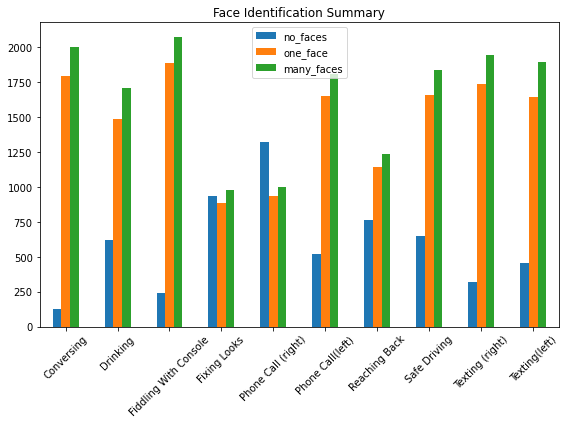

In [4]:
def summary(summary_csv):
    df_summary = pd.read_csv(summary_csv)
    df_summary['class_name'] = df_summary['class'].map(config.class_dict)
    
    df_0 = df_summary[df_summary['num_faces'] == 0].groupby('class_name').agg(
        no_faces=pd.NamedAgg(column="filename", aggfunc="count")
    )
    df_1 = df_summary[df_summary['num_faces'] == 1].groupby('class_name').agg(
        one_face=pd.NamedAgg(column="filename", aggfunc="count")
    )
    df_gt_1 = df_summary[df_summary['num_faces'] > 0].groupby('class_name').agg(
        many_faces=pd.NamedAgg(column="filename", aggfunc="count")
    )
    
    pd_merged = pd.merge(pd.merge(df_0, df_1, on='class_name'), df_gt_1, on='class_name')
    pd_merged.plot(title='Face Identification Summary', figsize=(8, 6), kind='bar', 
                   ylabel='', xlabel='', rot=45, grid=False)
    plt.tight_layout()
    plt.show()
    
summary(f'{face_config.FEATURES_FOLDER}/{face_config.FACE_SUMMARY_NAME}')


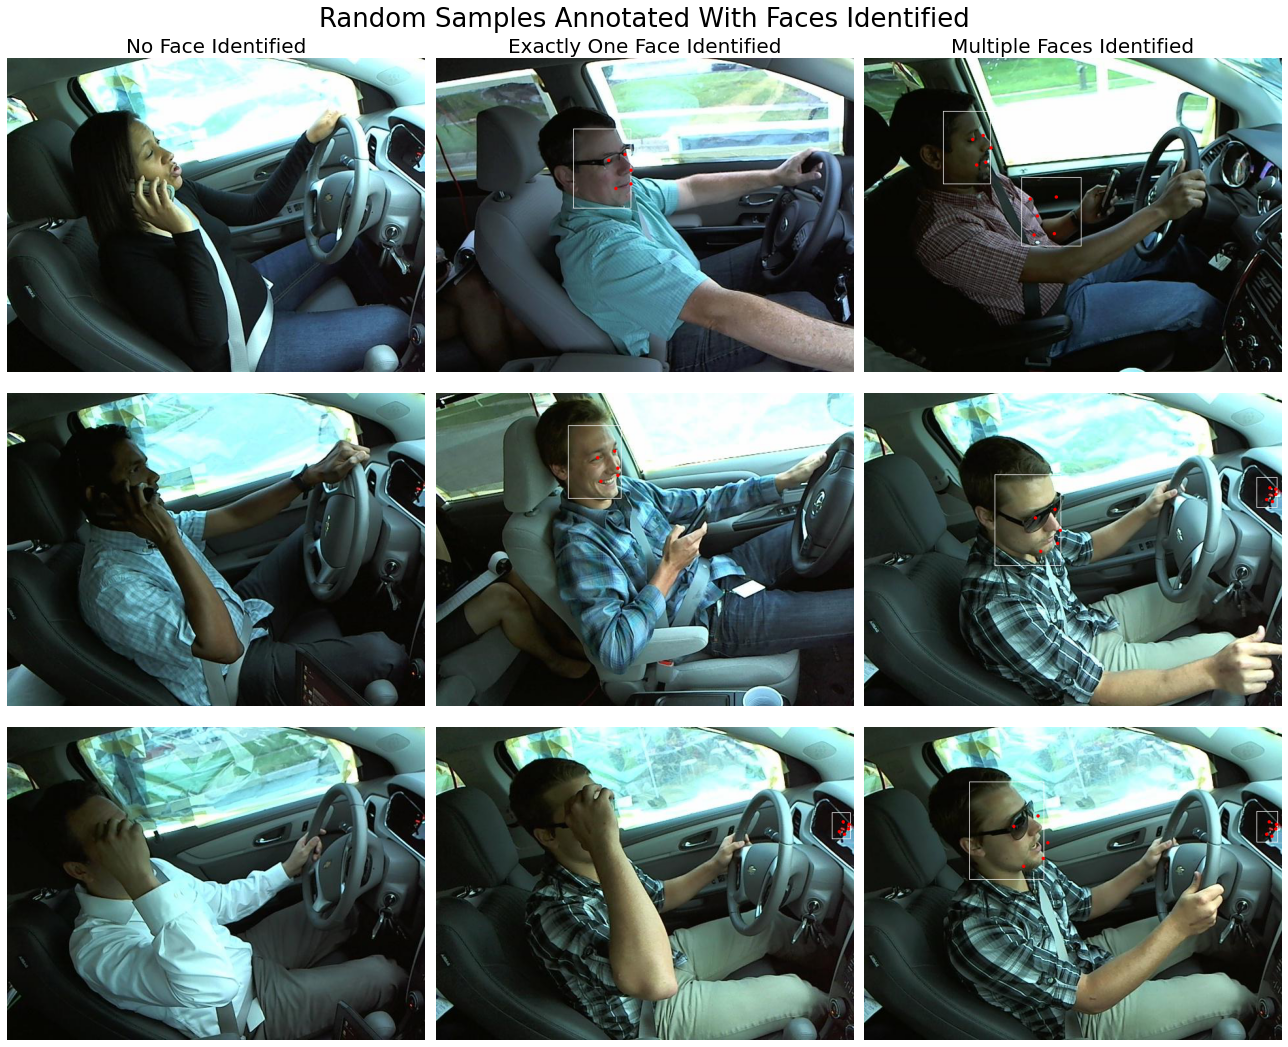

In [11]:
# Display the results of face detection.
def display_faces(per_group_count=3):
    def get_images(sample_type):
        dataset = customdataset.MainDataset(config, face_config, pose_config,
                                            sample_type=sample_type,
                                            image_types=[enums.ImageTypes.FACE_ANNOTATED])
        
        dataloader = DataLoader(dataset, num_workers=0, batch_size=1,
                                shuffle=True, collate_fn=dataset.get_image_from)
        sampled = []
        for i, sample in enumerate(dataloader):
            if i >= per_group_count:
                break
            images, label, filename = sample
            image = images[enums.ImageTypes.FACE_ANNOTATED]
            sampled.append(image)
        return sampled
    
    fig, axes = plt.subplots(per_group_count, 3, figsize=[18, 15], dpi=72)
    sampled = list(zip(get_images(enums.SampleType.WITH_NO_FACE),
                       get_images(enums.SampleType.WITH_JUST_ONE_FACE), 
                       get_images(enums.SampleType.WITH_MORE_THAN_ONE_FACE)))
    titles = ['No Face Identified', 'Exactly One Face Identified', 'Multiple Faces Identified']
    for i in range(per_group_count):
        for j, image in enumerate(sampled[i]):
            if i == 0:
                axes[i][j].set_title(titles[j], fontsize = 20)
            axes[i][j].imshow(image)
            axes[i][j].axis('off')
    plt.suptitle('Random Samples Annotated With Faces Identified', fontsize = 26)
    plt.tight_layout()
    plt.show()
    
display_faces(per_group_count = 3)

## Step 3: Train-Test-Validation Split
1. Face detection and extraction using MTCNN
2. Take 600 images with at least one face identified in each class
3. Create a 80-10-10 split to represent the train-validation-test split.

In [4]:
def split_dataset():
    splitter = eda_helpers.SampleSplitter(config, face_config, pose_config, tqdm=tqdm)
    splitter.sample(config.class_dict.keys(), samples_per_class=[600, 480, 60, 60], out_file=config.ANNOTATION_FILE)

split_dataset()

Total samples: 22424


  0%|          | 0/6000 [00:00<?, ?file/s]

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [int]

## Step 4: Pose Detection For Train-Test-Validation Datasets

In [17]:
%%time
pose_config = configuration.PoseConfig(config)
def extract_pose():
    original_backend = matplotlib.get_backend()
    print(f'Switching MatPlotLib backend from {original_backend} to Agg')
    # Pose extraction uses plt's canvas. We need a non-interactive backend to avoid memory leaks.
    matplotlib.use('Agg')
    
    pose_extractor = eda_helpers.PoseExtractor(config, face_config, pose_config, tqdm)
    pose_extractor.extract_poses(pose_config.FEATURES_FOLDER, pose_config.SUMMARY_NAME)
    # pose_extractor.extract_poses(f'{config.OUTPUT_FOLDER}/tt', pose_config.SUMMARY_NAME)
    matplotlib.use(original_backend)

extract_pose()

Switching MatPlotLib backend from agg to Agg
Loading model...


2022-12-06 17:19:36.502881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-06 17:19:36.503891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


0it [00:00, ?it/s]

TypeError: __init__() got an unexpected keyword argument 'label'

In [18]:
def display_poses(rows=3):
    dataset = customdataset.MainDataset(config, face_config, pose_config,
                                        sample_type=enums.SampleType.TRAIN_VALIDATION,
                                        image_types=[enums.ImageTypes.ORIGINAL, enums.ImageTypes.POSE_ANNOTATED, enums.ImageTypes.POSE])

    dataloader = DataLoader(dataset, num_workers=0, batch_size=1,
                            shuffle=True, collate_fn=dataset.get_image_from)
    fig, axes = plt.subplots(rows, 3, figsize=[18, 15], dpi=72)
    axes[0][0].set_title('Original', fontsize = 20)
    axes[0][1].set_title('Annotated With Pose', fontsize = 20)
    axes[0][2].set_title('Pose Extracted', fontsize = 20)

    for i, sample in enumerate(dataloader):
        if i >= rows:
            break
        images, label, filename = sample
        axes[i][0].imshow(images[enums.ImageTypes.ORIGINAL])
        axes[i][0].axis('off')
        axes[i][1].imshow(images[enums.ImageTypes.POSE_ANNOTATED])
        axes[i][1].axis('off')
        axes[i][2].imshow(images[enums.ImageTypes.POSE])
        axes[i][2].axis('off')
    plt.suptitle('Random Samples Annotated With Poses', fontsize = 26)
    plt.tight_layout()
    plt.show()
    
display_poses(rows=3)

ValueError: num_samples should be a positive integer value, but got num_samples=0

## Step 5: Extract Feature Vectors

In [ ]:
%%time  
# faces, original_images, poses, y, filenames = load_data(30, other_types=[enums.ImageTypes.ORIGINAL, enums.ImageTypes.POSE, enums.ImageTypes.FACE], included_labels=config.included_labels)
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)
data = feature_extractor.load_data(image_types=IMAGE_TYPES, sample_type=enums.SampleType.TRAIN_TEST_VALIDATION, shuffle=True)

In [ ]:
%%time

hog_features, hogs = feature_extractor.get_hog_features(data[enums.ImageTypes.FACE.name.lower()])

In [ ]:
%%time
pixel_features = feature_extractor.get_pixel_features(data[enums.ImageTypes.FACE.name.lower()])

In [ ]:
%%time
# GPU does not seemt to help much.
cnn_features = feature_extractor.get_cnn_features(data[enums.ImageTypes.ORIGINAL.name.lower()], device='cpu')

In [ ]:
%%time
canny_features, cannies = feature_extractor.get_canny_features(data[enums.ImageTypes.FACE.name.lower()])

In [ ]:
%%time
pose_features = feature_extractor.get_pixel_features(data[enums.ImageTypes.POSE.name.lower()])

In [ ]:
%%time
# Save the generated feature vectors.
features_list = [pixel_features, hog_features, cnn_features, canny_features, pose_features]
feature_extractor.save_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'], features_list)

In [ ]:
print(f'Loaded {data.shape[0]} samples.')
print(f'hog_features:{hog_features.shape}, hog_features.min:{np.min(hog_features)}, hog_features.max:{np.max(hog_features)}')
print(f'pixel_features:{pixel_features.shape}, pixel_features.min:{np.min(pixel_features)}, pixel_features.max:{np.max(pixel_features)}')
print(f'cnn_features:{cnn_features.shape}, cnn_features.min:{np.min(cnn_features)}, cnn_features.max:{np.max(cnn_features)}')
print(f'canny_features:{canny_features.shape}, canny_features.min:{np.min(canny_features)}, canny_features.max:{np.max(canny_features)}')
print(f'pose_features:{pose_features.shape}, pose_features.min:{np.min(pose_features)}, pose_features.max:{np.max(pose_features)}')
print()


## Step 6. Visualize Features

In [ ]:
def plot_features(included_labels):
    def display_img(ax_idx, img, row_name, col_name, first_row, first_col):
        ax = axes[ax_idx]
        ax.imshow(img, cmap='gray')
        if first_row:
            ax.set_title(col_name, fontsize=32)
        if first_col:
            ax.set_ylabel(row_name, fontsize = 32)
        ax.xaxis.set_major_locator(ticker.NullLocator())
        ax.yaxis.set_major_locator(ticker.NullLocator())
        
    # Load the data
    image_types = [
        enums.ImageTypes.FACE_ANNOTATED,
        enums.ImageTypes.POSE_ANNOTATED,
        enums.ImageTypes.ORIGINAL,
        enums.ImageTypes.POSE, 
        enums.ImageTypes.FACE
    ]
    count_per_label = 1
    data = feature_extractor.load_data(image_types=image_types, shuffle=True, 
                                       sample_type=enums.SampleType.TRAIN_VALIDATION,
                                       count_per_label=count_per_label, include_feature_vectors=True)
    _, hogs = feature_extractor.get_hog_features(data[enums.DataColumn.FACE.value])
    data['hog_img'] = hogs
    _, cannies = feature_extractor.get_canny_features(data[enums.DataColumn.FACE.value])
    data['canny_img'] = cannies
    
    fig, axes = plt.subplots(nrows=len(included_labels), ncols=len(image_types) + 2, figsize=[36, 48], dpi=72)
    axes = axes.flatten()
    first_row = True
    with tqdm(unit='images', desc=f'Loading image', total=len(included_labels)*len(image_types) + 2) as pbar:
        for i, cur_label in enumerate(included_labels):
            label_df = data[data['label'] == cur_label]
            for index, row in label_df.iterrows():
                cur_filename = row[enums.DataColumn.FILENAME.value]
                face_annotated_img = row[enums.DataColumn.FACE_ANNOTATED.value]
                pose_annotated_img = row[enums.DataColumn.POSE_ANNOTATED.value]
                original_img = row[enums.DataColumn.ORIGINAL.value]
                pose_img = row[enums.DataColumn.POSE.value]
                face_img = row[enums.DataColumn.FACE.value]
                hog = row['hog_img']
                canny = row['canny_img']

                imgs_to_display = [
                    ('Original', original_img),
                    ('Face Annotated', face_annotated_img),
                    ('Face Extracted', face_img),
                    ('Face - Canny', canny),
                    ('Face - Hog', hog),
                    ('Pose Annotated', pose_annotated_img),
                    ('Pose Extracted', pose_img)
                ]
                images_per_label = len(imgs_to_display)
                first_col = True
                for j, item in enumerate(imgs_to_display):
                    col_name, img = item
                    row_name = config.class_dict[cur_label]
                    display_img(i * images_per_label + j, img, row_name, col_name, first_row, first_col)
                    pbar.update(1)
                    first_col = False
            first_row = False

        plt.suptitle('Visualizing The Features', fontsize=48)
        plt.tight_layout(pad=4, h_pad=None, w_pad=None, rect=None)
        plt.show()

plot_features(included_labels=config.class_dict.keys())